In [20]:
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
style = {'description_width': 'initial'}
layout = Layout(width = '400px')
models = [None] * 4 

## Реалізація МНКО

In [21]:
def RMNK(X, y, verbose=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        w, H_inv = RMNK(X[:,:-1], y, verbose=verbose) # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]
        h = X[:,:-1].T @ X[:,-1] # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T * alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T, (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        
    if verbose:
        print('=============================================')
        print('\tStep {}'.format(m))
        print('=============================================')
        print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
        print('eta_{}:\t\t{}'.format(m, eta))
        print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
        print('beta_{}:\t\t{}'.format(m, beta))
        print('gamma_{}:\t{}'.format(m, gamma))
        print('nu_{}:\t\t{}'.format(m, nu))
        print('=============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
    return w, H_next_inv

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace - \enspace різниця\:вперед$
### $N'(t)≈ N(t)-N(t-1) \enspace - \enspace різниця\:назад$
### $N'(t)≈ \frac{N(t+1)-N(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $Розглядатимемо\: для\: різниці\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1\\
                  θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
### $ \Rightarrow \left \{ \begin{array}{ll}
                  μ = -θ_2 \\
                  k = (1 - θ_1) / θ_2
                \end{array}
              \right. $

In [22]:
# Lab 1
def model1(k, μ, N0):
    
    def model1_eq(N, t):
        return μ * N * (k - N)
    
    t = np.linspace(0, 30, num=200)

    # solve ODE
    N = odeint(model1_eq, N0, t)

    # plot results
    plt.plot(t,N)
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

description1 = Label(value="$N'=μN(k-N)$")
k_val = FloatText(value= 15, description = 'Ємність середовища (гранична чисельність): $k = $', step=0.1, style = style, layout = layout)
μ_val = FloatText(value = 0.05, description = 'Швидкість росту популяції: $μ = $', step=0.1, style = style, layout = layout)
N0_val = FloatText(value=0.5, description = 'Початковий розмір популяції: $N_0 = $', step=0.1, style = style, layout = layout)
models[0] = VBox([description1, interactive(model1, k=k_val, μ=μ_val, N0=N0_val, continuous_update=True)])

# display(models[0])

Initial parameters:	μ = 0.0001
			k = 100
			N0 = 10

Noise generationn: C = 3
Sample length: n = 50
Time starting from 0 to 500 with discretization frequency 10



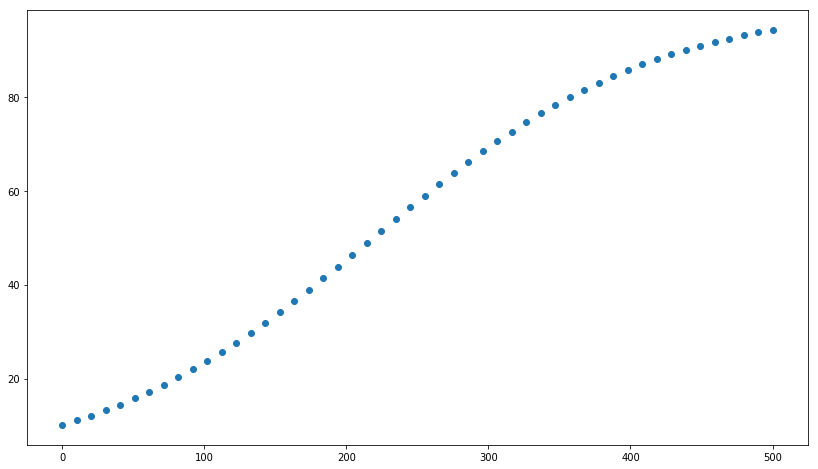

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [39]:
# Lab 2
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\tk = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generationn: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
    
    
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[59837637.56477976]
gamma_2:	14893552.79759949
nu_2:		[-0.0001]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189054	θ_2* = -0.00010000341994466655

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994466655	k* = 99.9910105518219


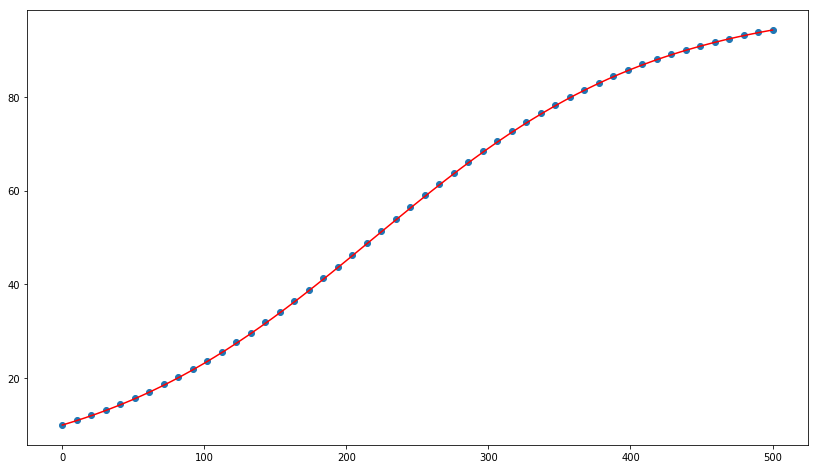

In [24]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True)[0][:,0]
μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tμ = {}\tk = {}'.format(config.μ, config.k))
print('Estimates:\tμ* = {}\tk* = {}'.format(μ_pred, k_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Verhulst_model_equation, config.N0, t_for_plot, (μ_pred, k_pred)), 'r')
plt.show()

In [26]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'μ*', 'k*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'μ*': μ_pred, 'k*': k_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tμ = {}\tk = {}'.format(config.μ, float(config.k)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['μ*', 'k*']]], axis=1)

True inter. params values:	θ_1 = 1.01	θ_2 = -0.0001
True init.  params values:	μ = 0.0001	k = 100.0


,C,num_samples,θ_1*,θ_2*,μ*,k*
0,0.0,10.0,0.998957,0.000044,-0.000044,23.826999
1,0.0,50.0,1.010265,-0.000106,0.000106,96.768521
2,0.0,100.0,1.009688,-0.000097,0.000097,100.083587
3,2.0,10.0,1.009857,-0.000098,0.000098,100.559471
4,2.0,50.0,1.009994,-0.000100,0.000100,100.105598
5,2.0,100.0,1.009956,-0.000099,0.000099,100.113571
6,5.0,10.0,1.010000,-0.000100,0.000100,100.000233
7,5.0,50.0,1.010000,-0.000100,0.000100,100.000141
8,5.0,100.0,1.010000,-0.000100,0.000100,100.000091


---

## 2. Рівняння вимушених коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t) \enspace - \enspace різниця\:вперед$
### $x'(t)≈ x(t)-x(t-1) \enspace - \enspace різниця\:назад$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $Розглянемо\: для\: апроксимації\: різницею\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}\\
                  θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
              

In [27]:
# Lab 1
def model3(δ, ω0, ω, f0, x0, x00):
    #x_0' = x_1 = x'
    #x_1' = x'' = f0 * np.cos(ω * t) - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    def model3_eq(x,t):
        return [x[1], f0 * np.cos(ω * t) - 2 * δ * x[1] - (ω0 ** 2) * x[0]]

    t = np.linspace(0,300, num=1000)

    # solve ODE
    x = odeint(model3_eq, np.array([x0, x00]), t)

    # plot results
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(t, x[:,0])
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x(t)')
    ax[1].plot(x[:,0], x[:,1])
    ax[1].set_xlabel('x(t)')
    ax[1].set_ylabel("x'(t)")
    plt.show()

description3 = Label(value="$x''+2δ x'+ω_0^2 x=f_0 cos(ωt)$")
δ_val = FloatText( description = 'Коефіцієнт згасання: $δ = $', step=0.1, style = style, layout = layout)
ω0_val = FloatText(description = 'Власна частота: $ω_0 = $', step=0.1, style = style, layout = layout)
ω_val = FloatText(description = 'Частота зовнішньої сили: $ω = $', step=0.1, style = style, layout = layout)
f0_val = FloatText(description = 'Амплітуда зовнішньої сили: $f_0 = $', step=0.1, style = style, layout = layout)
x0_val = FloatText( description = 'Початкове положення: $x_0 = $', step=0.1, style = style, layout = layout)
x00_val = FloatText(description = "Початкова швидкіть: $x_0' = $", step=0.1, style = style, layout = layout)
models[2] = VBox([description3, interactive(model3, δ=δ_val, ω0=ω0_val, ω=ω_val, f0=f0_val, x0=x0_val, x00=x00_val, continuous_update=True)])

# display(models[2])

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generationn: C = 2
Sample length: n = 80
Time starting from 0 to 500 with discretization frequency 6



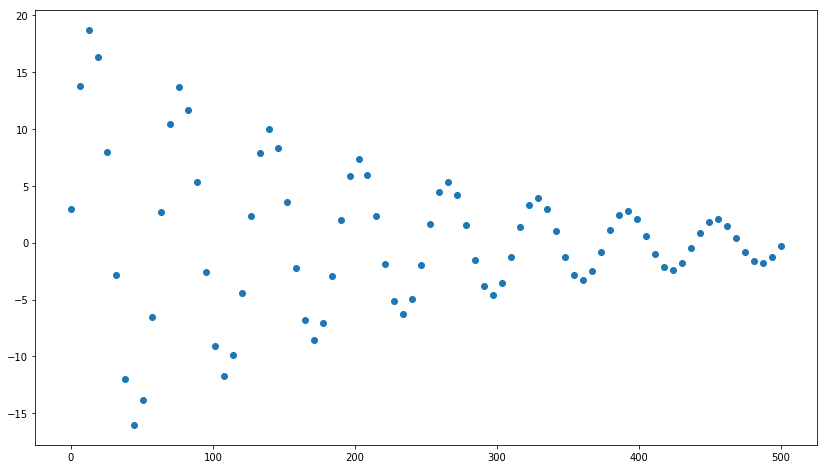

Intermediate parameters values: θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Regression model: y = (1.98019801980198) * x1 + (-0.9900990099009901) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [41]:
# Lab 2
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]
        

class OscillationModelConfig(): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation, np.array([self.x0, self.x00]), self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation, np.array([self.x1, self.x11]), self.t+1, (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr, self.x0, self.x00))
        print('Noise generationn: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        divider = 1 + 2 * self.δ
        w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
        w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = - (1 / w2 + 1) / 2
        ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
        
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.3120437748094
nu_1:		[0.95802084]
> θ_1: [0.95802084]
> H_1_inv:
[[0.00028604]]
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[30.02371322]
gamma_2:	3428.298727481169
nu_2:		[-0.99045368]
> θ_2: [ 1.98062616 -0.99045368]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Estimates:	θ_1* = 1.9806261560117373	θ_2* = -0.9904536768605925

INITIAL PARAMETERS
True values:	δ = 0.005	ω0^2 = 0.01
Estimates:	δ* = 0.004819166894137972	ω0^2* = 0.009922241775107699


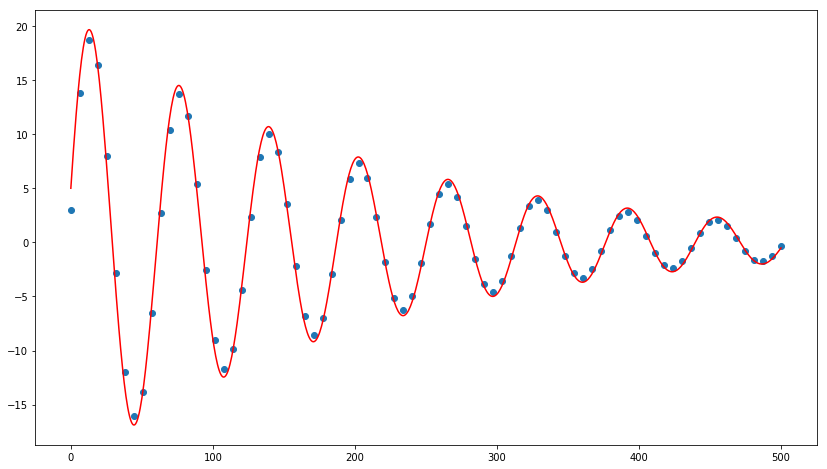

In [42]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0, config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [43]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred, ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\tω0^2 = {}'.format(config.δ, float(config.ω0_sqr)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
True init.  params values:	δ = 0.005	ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922
5,2.0,150.0,1.980007,-0.989910,0.005096,0.010005
6,5.0,30.0,1.980197,-0.990098,0.005001,0.010000
7,5.0,80.0,1.980199,-0.990100,0.005000,0.010000
8,5.0,150.0,1.980197,-0.990098,0.005000,0.010000


### $Розглянемо\: для\: апроксимації\: центральною\: різницею:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+δ[x(t+1)-x(t-1)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2-ω_0^2}{1+δ}x(t+1)-\frac{1-δ}{1+δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2-ω_0^2}{1+δ}\\
                  θ_2 = -\frac{1-δ}{1+δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generationn: C = 2
Sample length: n = 80
Time starting from 0 to 500 with discretization frequency 6



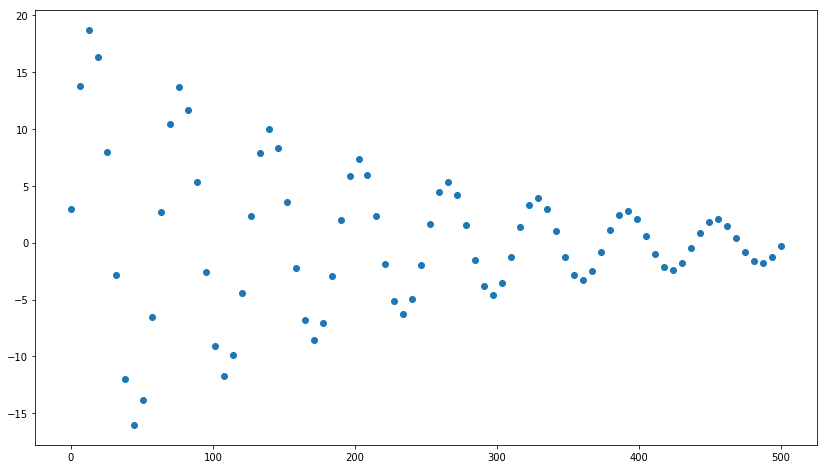

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [44]:
# Lab 2
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]
        

class OscillationModelConfig_center(OscillationModelConfig): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def init_to_inter_params(self):
        divider = 1 + self.δ
        w1 = (2 - self.ω0_sqr) / divider
        w2 = - (1 - self.δ) / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = (1 + w2) / (1 - w2)
        ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        return δ, ω0_sqr
        
config = OscillationModelConfig_center()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[30.02371322]
gamma_2:	3428.2668093266866
nu_2:		[-0.99035405]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.9805136264573653	θ_2* = -0.9903540525860844

INITIAL PARAMETERS
True values:	δ = 0.005	ω0^2 = 0.01
Estimates:	δ* = 0.004846347513590607	ω0^2* = 0.00988811625342075


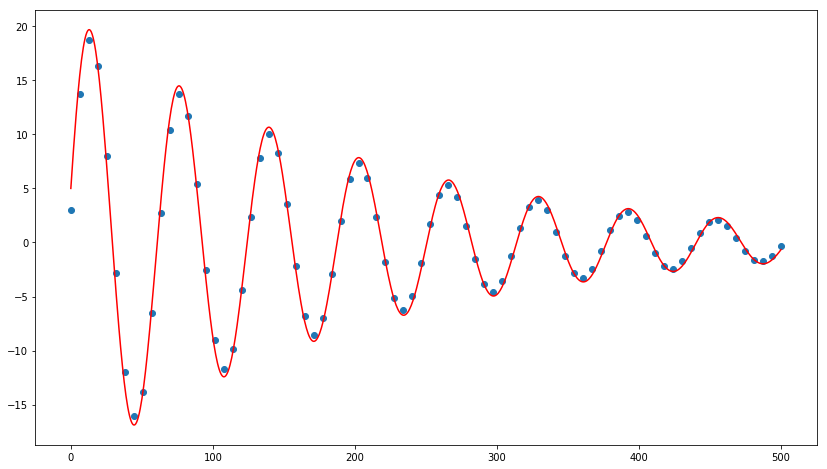

In [45]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0, config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [50]:
center_intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
center_initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        center_intermediate_estimates_df = \
        center_intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        center_initial_estimates_df = \
        center_initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred, ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\tω0^2 = {}'.format(config.δ, float(config.ω0_sqr)))
pd.concat([center_intermediate_estimates_df, center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
True init.  params values:	δ = 0.005	ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888
5,2.0,150.0,1.979936,-0.989861,0.005095,0.009975
6,5.0,30.0,1.980099,-0.990050,0.005000,0.010000
7,5.0,80.0,1.980099,-0.990050,0.005000,0.010000
8,5.0,150.0,1.980100,-0.990050,0.005000,0.010000


In [66]:
center_df = pd.concat([center_intermediate_estimates_df, center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
center_df['difference'] = 'center'
forward_df = pd.concat([intermediate_estimates_df, initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
forward_df['difference'] = 'forward'

pd.concat([center_df, forward_df], axis=0).sort_values(by=['C', 'num_samples', 'difference'])

,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*,difference
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134,center
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134,forward
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574,center
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574,forward
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481,center
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481,forward
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935,center
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935,forward
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888,center
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888,forward
